In [1]:
import pandas as pd
from tqdm.notebook import tqdm as tqdm_notebook
import re
from collections import defaultdict
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
import seaborn as sns
import gensim
from gensim.utils import simple_preprocess
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import nltk
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from gensim.sklearn_api import TfIdfTransformer
from gensim.corpora import Dictionary
from nltk.util import everygrams
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.topic_coherence import direct_confirmation_measure
from my_custom_module import custom_log_ratio_measure
import pyLDAvis.gensim_models
import pyLDAvis
pyLDAvis.enable_notebook()
direct_confirmation_measure.log_ratio_measure = custom_log_ratio_measure
!pip install stop-words
%matplotlib inline

In [2]:
FILE_ORIGIN = '../dblpv13.json'
FILE_PREPROCESSED = '../data.json'

In [3]:
CHUNKSIZE = 100000
MAX_OBSERVATIONS = 1000000 #Set to 55000000 if want all rows
df = pd.DataFrame()
with pd.read_json(FILE_PREPROCESSED, orient='records', lines=True, chunksize=CHUNKSIZE, nrows=MAX_OBSERVATIONS) as reader:
    for chunk_i, chunk in tqdm_notebook(enumerate(reader), total=MAX_OBSERVATIONS // CHUNKSIZE):
        df_new = pd.DataFrame(chunk)
        df_new['chunk_idx'] = chunk_i
        df = pd.concat([df, df_new], ignore_index=True)

  0%|          | 0/10 [00:00<?, ?it/s]

In [4]:
df.head()

,_id,title,venue,year,keywords,n_citation,lang,authors,fos,page_start,...,volume,issue,issn,isbn,doi,pdf,url,abstract,references,chunk_idx
0,53e99784b7602d9701f3e3f5,3GIO.,{'type': 0},2011.0,[],0.0,en,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,53e99784b7602d9701f3e133,The relationship between canopy parameters and...,"{'_id': '53a7297d20f7420be8bd4ae7', 'name_d': ...",2011.0,"[canopy parameters, canopy spectrum, different...",0.0,en,"[{'_id': '53f45728dabfaec09f209538', 'name': '...","[Agronomy, Moisture, Hydrology, Environmental ...",1930,...,null,null,,,10.1109/IGARSS.2011.6049503,None,[http://dx.doi.org/10.1109/IGARSS.2011.6049503],Drought is the first place in all the natural ...,NaN,0
2,53e99784b7602d9701f3e151,A solution to the problem of touching and brok...,"{'_id': '53a72a4920f7420be8bfa51b', 'name_d': ...",1993.0,"[handwriting recognition, prototypes, image se...",17.0,en,"[{'_id': '53f46797dabfaeb22f542630', 'name': '...","[Intelligent character recognition, Pattern re...",602,...,,,,,10.1109/ICDAR.1993.395663,None,[http://dx.doi.org/10.1109/ICDAR.1993.395663],,"[53e99cf5b7602d97025ace63, 557e8a7a6fee0fe990c...",0
3,53e99784b7602d9701f3e15d,Timing yield estimation using statistical stat...,"{'_id': '53a72e2020f7420be8c80142', 'name_d': ...",2005.0,"[sequential circuits, statistical distribution...",28.0,en,"[{'_id': '53f43b03dabfaedce555bf2a', 'name': '...","[Delay calculation, Timing failure, Monte Carl...",2461,...,,,,0-7803-8834-8,10.1109/ISCAS.2005.1465124,//static.aminer.org/pdf/PDF/000/423/329/timing...,"[http://dx.doi.org/10.1109/ISCAS.2005.1465124,...",As process variations become a significant pro...,"[53e9a8a9b7602d97031f6bb9, 599c7b6b601a182cd27...",0
4,53e99784b7602d9701f3e161,360°,"{'_id': '5390a74a20f70186a0e8b40b', 'raw': 'AC...",2009.0,"[global high technology, daily short-distance ...",NaN,en,"[{'_id': '53f46946dabfaec09f24b4ed', 'name': '...",NaN,39,...,,,,,10.1145/1665137.1665166,NaN,NaN,360° represents the concerns that are addresse...,NaN,0


In [5]:
df.lang.value_counts()

en    999914
zh        86
Name: lang, dtype: int64

# Data Preprocessing

In [6]:
df_en = df[df.lang.eq('en')]

In [7]:
class GensimBoW:
    def __init__(self, dict_cleaning_frequency=100000, min_freq_abs=10, max_freq=0.8, keep_words=10000, ngram=2):
        self.stop_word = set(nltk.corpus.stopwords.words('english'))
        self.dictionary = Dictionary()
        self.ps = nltk.stem.PorterStemmer()
        self.dict_cleaning_frequency = dict_cleaning_frequency
        self.min_freq_abs = min_freq_abs
        self.max_freq = max_freq
        self.keep_words = keep_words
        self.ngram = ngram

    @staticmethod
    def _docs_to_words(docs):
        for doc in docs:
            yield(gensim.utils.simple_preprocess(str(doc), deacc=True))

    def _stemme(self, token):
        return self.ps.stem(token)
    
    def _check(self, token):
        return token not in self.stop_word

    def _ngrams(self, tokens):
        if self.ngram == 1:
            return tokens
        return (' '.join(a) for a in everygrams(tokens, max_len=self.ngram))

    def _filter_extremes(self):
        self.dictionary.filter_extremes(no_below=self.min_freq_abs, 
                                        no_above=self.max_freq, 
                                        keep_n=self.keep_words)
        self.dictionary.compactify()
    
    def _create_dictionary(self, X):
        for i, doc in enumerate(self._docs_to_words(X), 1):
            filtered_doc = [self._stemme(token) for token in doc if self._check(token)]
            self.dictionary.doc2bow(self._ngrams(filtered_doc), allow_update=True)
            if i % self.dict_cleaning_frequency == 0:
                self._filter_extremes()
        self._filter_extremes()

    def _get_BoW_corpus(self, X):
        BoW_corpus = []
        self._filtered_docs = []
        for i, doc in enumerate(self._docs_to_words(X), 1):
            filtered_doc = [self._stemme(token) for token in doc if self._check(token)]
            self._filtered_docs.append(filtered_doc)
            BoW_corpus.append(self.dictionary.doc2bow(self._ngrams(filtered_doc), allow_update=False))
        return BoW_corpus
    
    def fit(self, X, y=None):
        self._create_dictionary(X)
        return self

    def transform(self, X):
        return self._get_BoW_corpus(X)

In [8]:
BoW_model = GensimBoW()

In [9]:
BoW_model.fit(df_en['title'].head(10000))

In [10]:
BoW = BoW_model.transform(df_en['title'].head(10000))

# Models

c_v understanding: 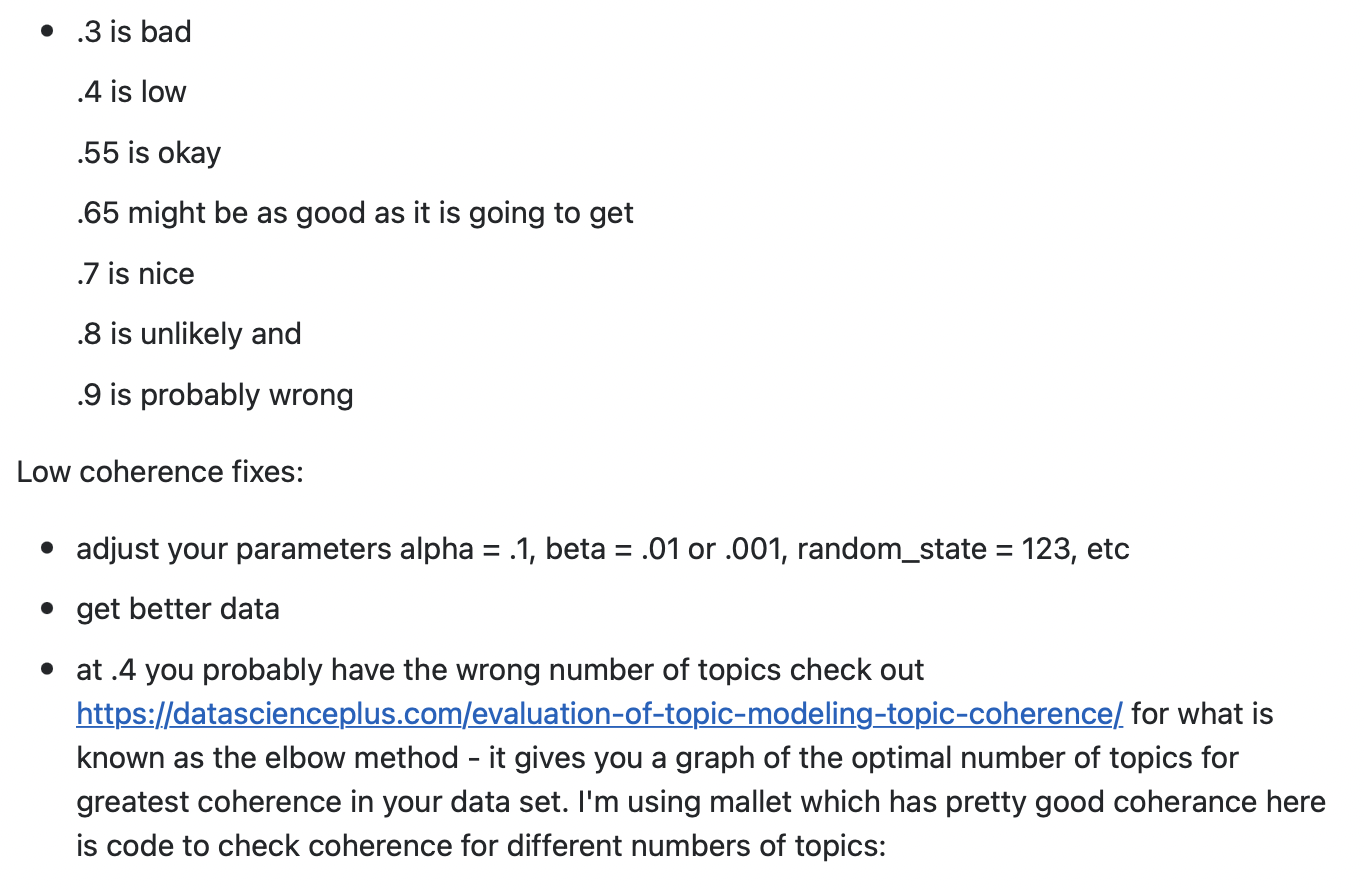

In [11]:
import numpy as np
class MyLdaModel:
    def __init__(self, corpus, dictionary, filtered_docs, *args, **kwargs):
        self.corpus = corpus
        self.dictionary = dictionary
        self.filtered_docs = filtered_docs
        self.model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            *args, **kwargs)

    def print_words_distributions(self, k=10):
        for topic_id in range(self.model.num_topics):
            topk = self.model.show_topic(topic_id, k)
            topk_words = [ w for w, _ in topk ]

            print('{}: {}'.format(topic_id, ' '.join(topk_words)))

    def plot_word_cloud(self, topn=50):
        for topic in range(self.model.num_topics):
            # Get topics and frequencies and store in a dictionary structure
            topic_words_freq = dict(self.model.show_topic(topic, topn=topn)) # NB. the 'dict()' constructor builds dictionaries from sequences (lists) of key-value pairs - this is needed as input for the 'generate_from_frequencies' word cloud function
            cloud = WordCloud(max_font_size=80, colormap="hsv").generate_from_frequencies(topic_words_freq)
            plt.figure(figsize=(16,12))
            plt.imshow(cloud, interpolation='bilinear')
            plt.axis('off')
            plt.title(f'WordCloud topic: {topic}', size=20)
            plt.show()

    def calculate_metrics(self):
        self.cm_cv = CoherenceModel(model=self.model, 
                                    texts=self.filtered_docs,
                                    coherence='c_v',
                                    dictionary=self.dictionary)
        
        self.cm_um = CoherenceModel(model=self.model, 
                                    texts=self.filtered_docs,
                                    coherence='u_mass',
                                    dictionary=self.dictionary)

        self.cm_w2v = CoherenceModel(model=self.model, 
                                     texts=self.filtered_docs,
                                     coherence='c_w2v',
                                     dictionary=self.dictionary)
        print('the lower the perplexity, the better the model. Not a good metric.')
        print(f'Perplexity: {self.model.log_perplexity(self.corpus)}')
        with np.errstate(invalid='ignore'):
            print(f'Coherence Score cv: {self.cm_cv.get_coherence()}, 0.5 - 0.8 - good')
        print(f'Coherence Score um: {self.cm_um.get_coherence()}, should be between -14 and 14 or so, 0 - worst')
        print(f'Coherence Score w2v: {self.cm_w2v.get_coherence()}, the bigger the better')

    def coherence_per_topic(self):
        coherence_per_topic = (self.cm_cv.get_coherence_per_topic(),
                               self.cm_um.get_coherence_per_topic(),
                               self.cm_w2v.get_coherence_per_topic())
        topics_str = []
        for topic_id in range(self.model.num_topics):
            topk = self.model.show_topic(topic_id, 4)
            topk_words = [ w for w, _ in topk ]
            topics_str.append('\n '.join(topk_words))
        metrics = ['Coherence Score cv', 'Coherence Score um', 'Coherence Score w2v']
        data_topic_score = pd.DataFrame(data=zip(topics_str, coherence_per_topic[0], coherence_per_topic[1], coherence_per_topic[2]),
                                        columns=['Topic'] +  metrics)
        data_topic_score = data_topic_score.set_index('Topic')
        fig, axes = plt.subplots(1, len(metrics), figsize=(16, 12))
        for metric, ax in zip(metrics, axes):
            ax.set_title(metric)
            sns.heatmap(data=data_topic_score[metric].to_frame(), annot=True, square=True,
                        cmap='Reds', fmt='.2f',
                        linecolor='black', ax=ax )
            plt.yticks( rotation=0 )
            ax.set_xlabel('')
            ax.set_ylabel('')
        fig.show()

    def plot_LDAvis(self):
        LDAvis_prepared = pyLDAvis.gensim_models.prepare(self.model, self.corpus, self.dictionary)
        return LDAvis_prepared

In [12]:
lda_model = MyLdaModel(corpus=BoW,
                       dictionary=BoW_model.dictionary,
                       filtered_docs=BoW_model._filtered_docs,
                       num_topics=10, 
                       random_state=123,
                       update_every=1,
                       chunksize=100000,
                       passes=2,
                       alpha='auto',
                       per_word_topics=True
                      )

In [13]:
lda_model.print_words_distributions()

0: editori gener guest editori guest note game beyond editori note depend conclus
1: book review book review databas calendar concurr constraint futur connect collabor
2: digit dynam function distribut author repli comment author repli architectur secur
3: foreword algorithm cluster model network electron analysi grammar robot messag
4: introduct design editor announc complex color map tree editor introduct die
5: prefac graph confer fuzzi code report logic theori construct letter
6: erratum confer control discuss errata group evolutionari vorwort revisit simul
7: comput correspond graphic cooper vision cover biometr summari fair structur
8: data news educ forum learn algebra introduct embed comput matter
9: review system program problem composit introduct book book review biographi ensembl


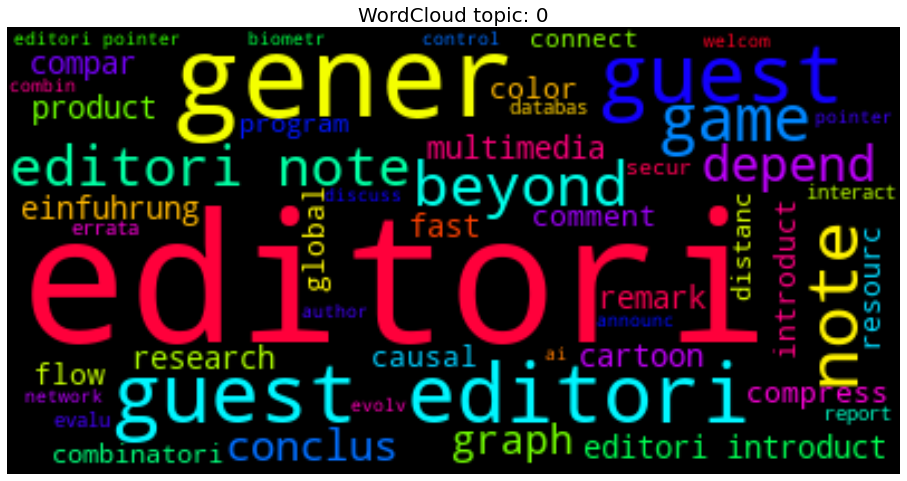

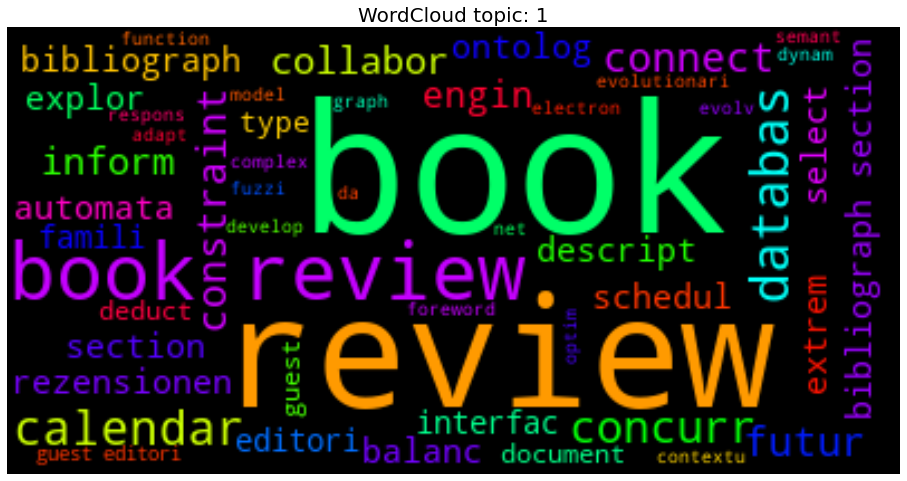

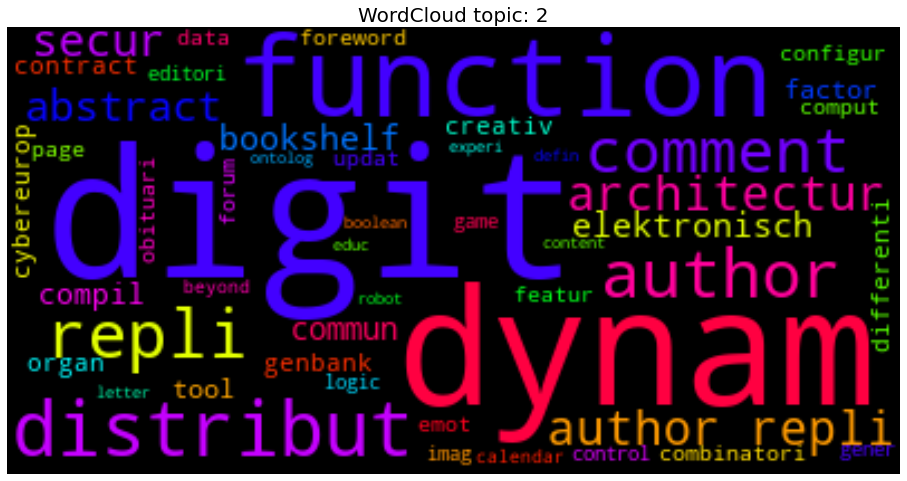

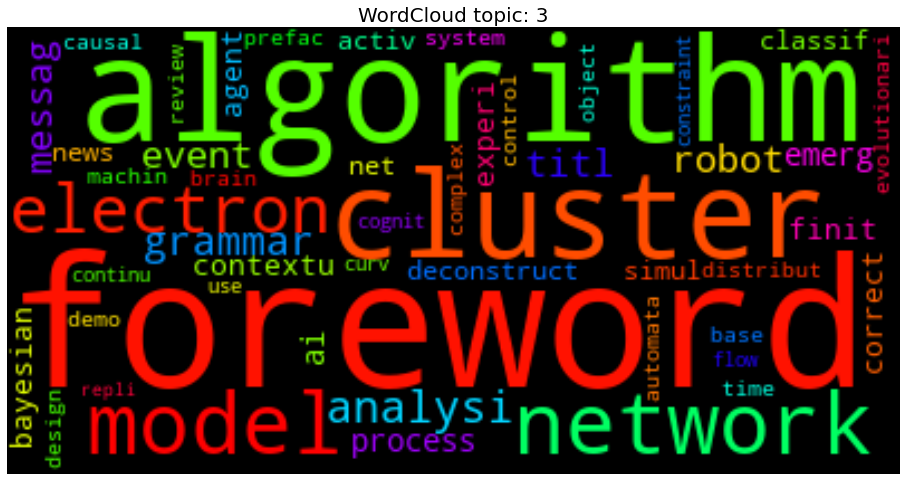

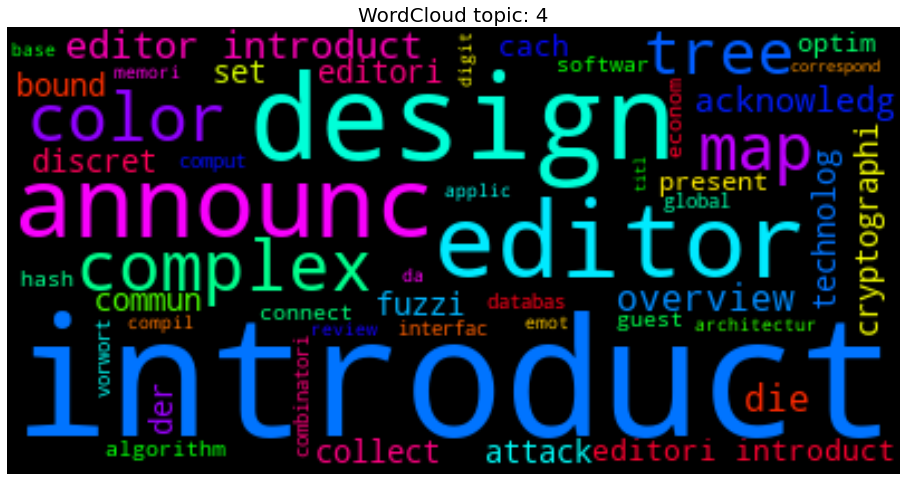

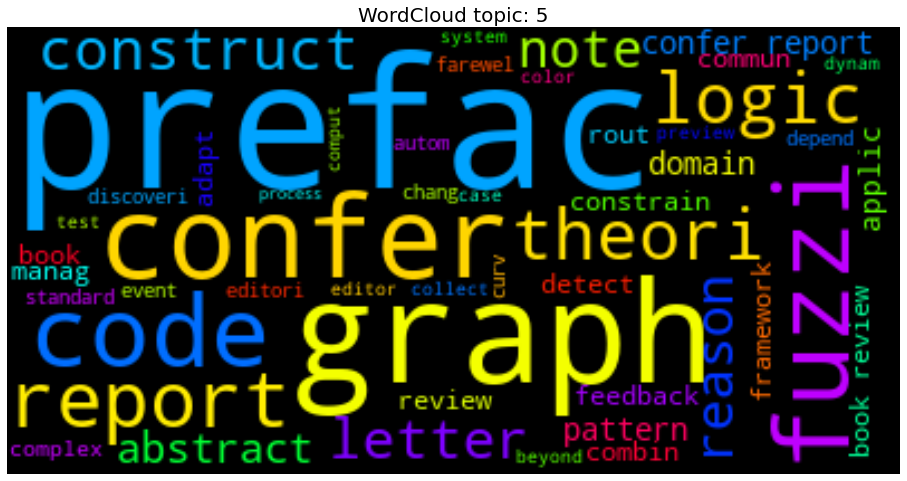

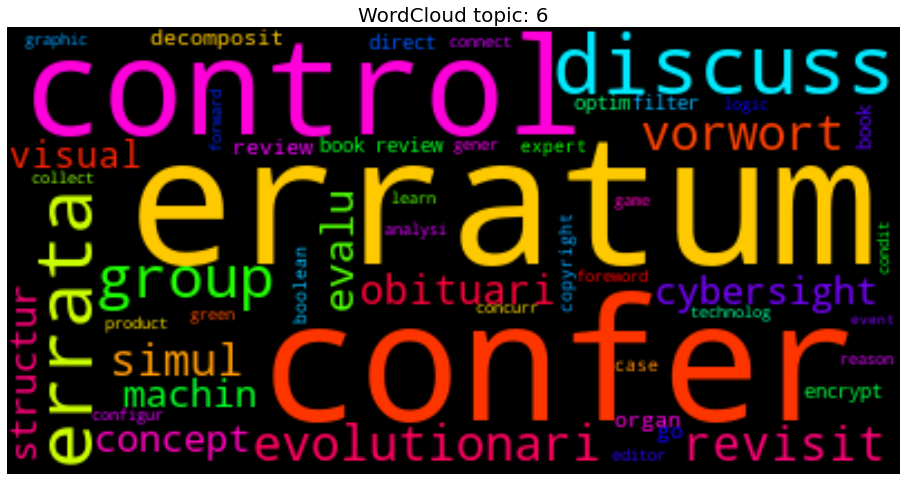

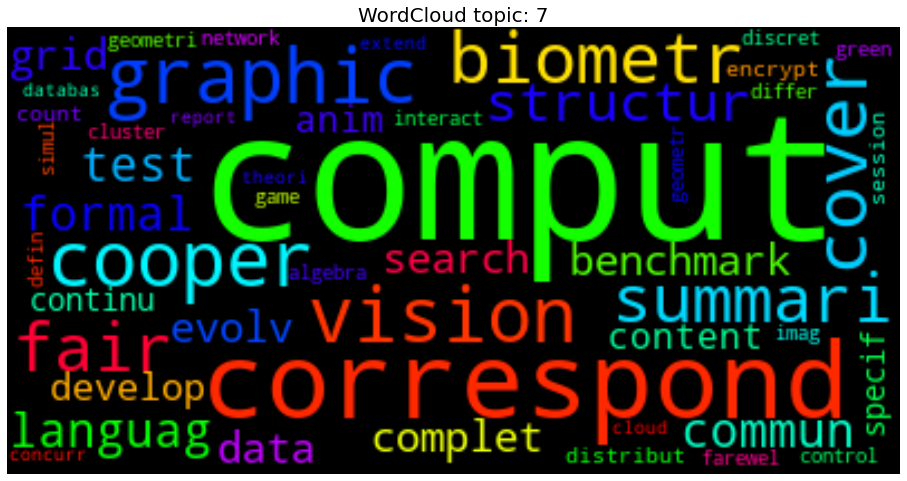

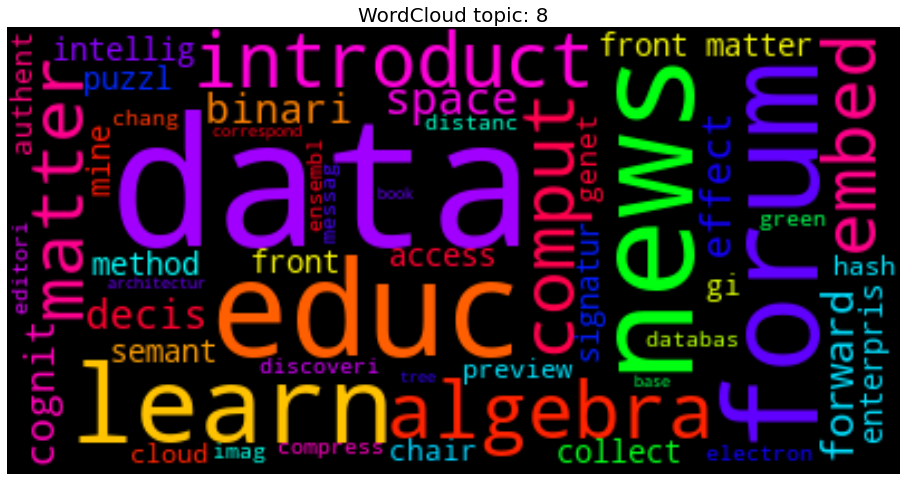

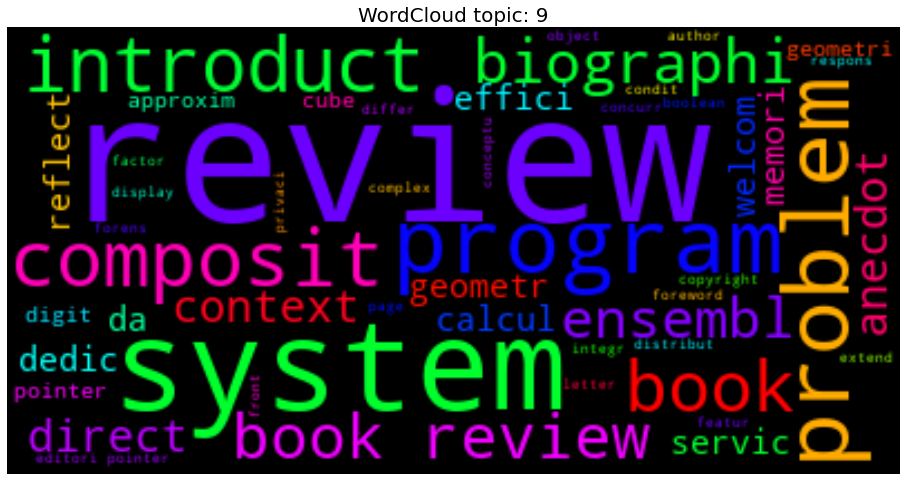

In [14]:
lda_model.plot_word_cloud()

In [15]:
lda_model.calculate_metrics()

the lower the perplexity, the better the model. Not a good metric.
Perplexity: -5.936338355659193
Coherence Score cv: 0.7986597755477336, 0.5 - 0.8 - good
Coherence Score um: -19.938997318119405, should be between -14 and 14 or so, 0 - worst
Coherence Score w2v: 0.2420257031917572, the bigger the better


/var/folders/r_/bq4swdms3vj5wr80yf1vm4nh0000gn/T/ipykernel_40078/2477636867.py:74: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


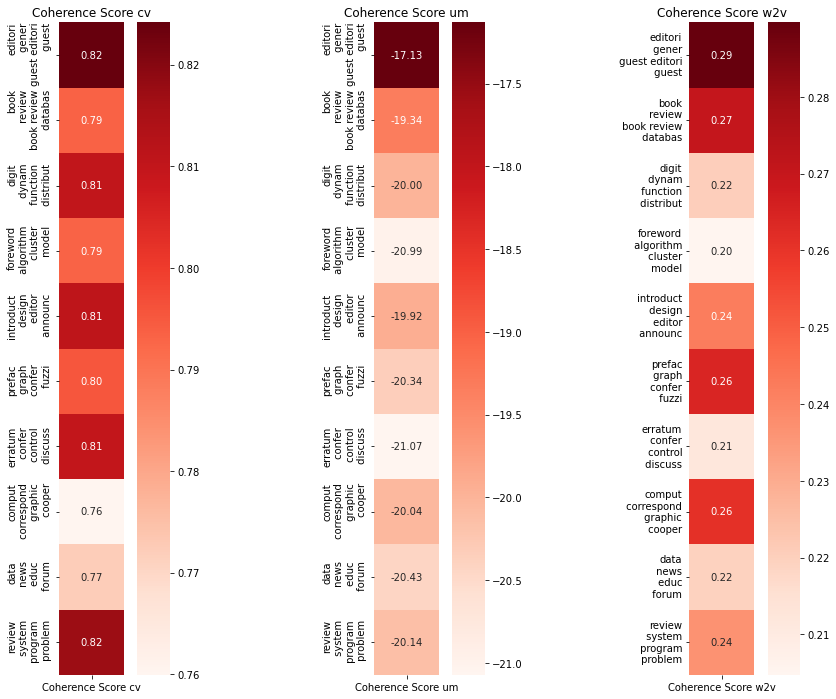

In [16]:
lda_model.coherence_per_topic()

In [17]:
lda_model.plot_LDAvis()

/Users/dmitriimaksimov/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/dmitriimaksimov/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/dmitriimaksimov/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/dmitriimaksimov/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/U

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.250608 -0.108705       1        1  12.472457
0     -0.182757 -0.245184       2        1  11.363188
3      0.052280  0.120998       3        1  10.858778
7     -0.055981  0.203759       4        1  10.169741
5      0.057566 -0.072908       5        1  10.031087
2     -0.111327  0.086835       6        1   9.930559
8     -0.107413  0.106137       7        1   9.414827
4     -0.135243 -0.099972       8        1   9.241295
9      0.158956 -0.016400       9        1   8.520787
6      0.073311  0.025439      10        1   7.997281, topic_info=            Term        Freq       Total Category  logprob  loglift
46       editori  274.000000  274.000000  Default  30.0000  30.0000
70        comput  203.000000  203.000000  Default  29.0000  29.0000
158       review  203.000000  203.000000  Default  28.0000  28.0000
61          book  167.000000  167.000000  Default  27.0000  27.0000
133    introduct  125.000000  125.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
144    technolog    3.349622   15.298361  Topic10  -5.0732   1.0072
125        learn    4.394187   24.501523  Topic10  -4.8017   0.8076
158       review    9.519589  203.924744  Topic10  -4.0286  -0.5383
277  book review    7.132163  126.791632  Topic10  -4.3174  -0.3519
61          book    7.132700  167.324030  Topic10  -4.3173  -0.6292

[373 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
104       1  0.029155  abstract
104       2  0.029155  abstract
104       4  0.029155  abstract
104       5  0.379015  abstract
104       6  0.495635  abstract
...     ...       ...       ...
138      10  0.787995   vorwort
137       2  0.161534    welcom
137       7  0.080767    welcom
137       8  0.080767    welcom
137       9  0.726902    welcom

[1284 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 8, 6, 3, 9, 5, 10, 7])

Each bubble on the left-hand side represents topic. The larger the bubble, the more prevalent or dominant the topic is. Good topic model will be fairly big topics scattered in different quadrants rather than being clustered on one quadrant.
The model with too many topics will have many overlaps, small sized bubbles clustered in one region of chart.